RNN의 문제점
```
기울기 소실(Vanishing Gradient)
  역전파 과정에서 손실이 과거시점으로 전달될때 기울기 값이 점점 작아지면서 0에 가까워지고 결국 학습이 안되는 현상
  - 학습과정에서 파악하기 어렵다
기울기 폭발(Expoding Gradient)
  특정상황에서 기울기 값이 너무 커져서 학습이 불안정해지는 현상
  코드상으로는 기울기 클리핑이 사용
장기 의존성 학습의 어려움
   데이터의 시퀸스가 길어질수록 초기 입력정보가 점점희미해지는 현상으로 초기 특성을 반영하지 못함
단순한 정보 저장
```

LSTM
```
  RNN과 동일하게 시퀸스를 처리, 셀상태와 게이트 개념을 도입
  망각게이트
    이전 셀 상태에서 삭제할 정보를 결정
    0이면 잊고 1이면 유지
```
$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$

```
입력게이트
  새로운 정보를 얼마나 저장할지 결정
  1. 새로운 정보를 저장, 0이면 저장안함
```

$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$

```
출력게이트
  최종적으로 어떤 정보를 은닉상태에 담아 다음 단계로 넘길지 결정하는 게이트
```

```
lstm의 정보처리 순서
  과거정보에서 버릴것은 버리고 (Foget Gate)
  새로운 정보를 받아들이고 (Input Gate)
  셀 상태 업데이트(망각게이트와 입력게이트의 출력을 사용해)
  출력게이트는 업데이트된 정보를 저장한뒤 (Out Gate)
  최종 결과를 출력
```

# LSTM 신경망
데이터 가져오기

In [ ]:
# 매 실행시 동일한 결과를 얻기 위해 시드값을 통일
import tensorflow as tf
import numpy as np
import pandas as pd


tf.keras.utils.set_random_seed(42)

In [ ]:
(train_data, train_target),(test_data, test_target) = tf.keras.datasets.imdb.load_data(num_words=500)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# 문장의 길이가 서로 같지 않다
[len(word) for word in train_data]
# 문장의 길이를 max_len으로 통일
#  sentence > max_len or sentence < max_len
max_len = 200
train_data_sequence \
  = tf.keras.preprocessing.sequence.pad_sequences(train_data, maxlen=max_len)

val_data_sequence \
  = tf.keras.preprocessing.sequence.pad_sequences(test_data, maxlen=max_len)

train_data_sequence.shape  , val_data_sequence.shape

((25000, 200), (25000, 200))

모델 만들기 LSTM

In [ ]:
# 함수형 API형식으로 만들기
input = tf.keras.Input(shape=(200,))
hidden = tf.keras.layers.Embedding(500, 16)(input)
hidden = tf.keras.layers.LSTM(8)(hidden)
output = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)
model = tf.keras.Model(input, output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 200, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best-model.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]
history = model.fit(train_data_sequence, train_target, epochs=20,
              batch_size=32, validation_data=(val_data_sequence, test_target),
              callbacks=callbacks)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6406 - loss: 0.6179
Epoch 1: val_loss improved from inf to 0.46676, saving model to best-model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 98ms/step - accuracy: 0.6407 - loss: 0.6179 - val_accuracy: 0.7906 - val_loss: 0.4668 - learning_rate: 0.0010
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7951 - loss: 0.4592
Epoch 2: val_loss improved from 0.46676 to 0.39987, saving model to best-model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 77s 98ms/step - accuracy: 0.7952 - loss: 0.4592 - val_accuracy: 0.8244 - val_loss: 0.3999 - learning_rate: 0.0010
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8181 - loss: 0.4135
Epoch 3: val_loss improved from 0.39987 to 0.38995, saving model to best-model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 80ms/step - accuracy: 0.8181 - loss: 0.4135 - val_accuracy: 0.8275 - val_loss: 0.3900 - learning_rate: 0.0010
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accu

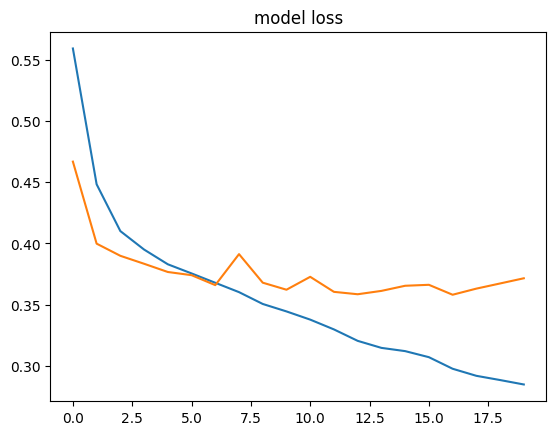

In [ ]:
import matplotlib.pyplot as plt
plt.title('model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
# 함수형 API형식으로 만들기 / 과적합을 고려해서 드랍아웃을 적용하고 다층으로 ㄱ성
input = tf.keras.Input(shape=(200,))
hidden = tf.keras.layers.Embedding(500, 16)(input)
hidden = tf.keras.layers.LSTM(8,dropout=0.3,return_sequences=True)(hidden)  # (None,8,200)
hidden = tf.keras.layers.LSTM(8,dropout=0.3)(hidden)  # (None,8)
output = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)
model = tf.keras.Model(input, output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 200, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 200, 8)              │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,353 (36.54 KB)

 Trainable params: 9,353 (36.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best-model.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]
history = model.fit(train_data_sequence, train_target, epochs=20,
              batch_size=32, validation_data=(val_data_sequence, test_target),
              callbacks=callbacks)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6147 - loss: 0.6290
Epoch 1: val_loss improved from inf to 0.44758, saving model to best-model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 152s 186ms/step - accuracy: 0.6148 - loss: 0.6290 - val_accuracy: 0.7992 - val_loss: 0.4476 - learning_rate: 0.0010
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7883 - loss: 0.4685
Epoch 2: val_loss improved from 0.44758 to 0.40637, saving model to best-model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 200s 184ms/step - accuracy: 0.7883 - loss: 0.4685 - val_accuracy: 0.8196 - val_loss: 0.4064 - learning_rate: 0.0010
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7879 - loss: 0.4579
Epoch 3: val_loss did not improve from 0.40637
782/782 ━━━━━━━━━━━━━━━━━━━━ 200s 182ms/step - accuracy: 0.7879 - loss: 0.4579 - val_accuracy: 0.8234 - val_loss: 0.4072 - learning_rate: 0.0010
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7996 - loss: 0.4487


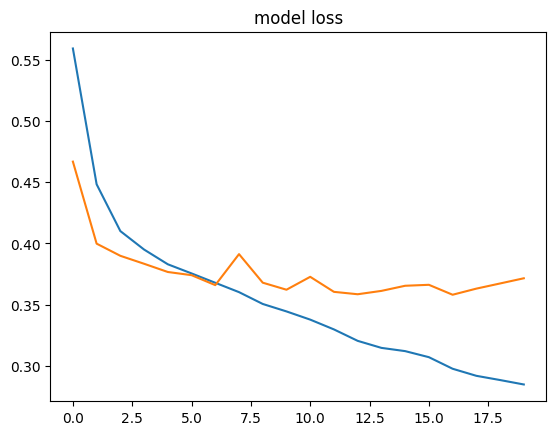

In [ ]:
import matplotlib.pyplot as plt
plt.title('model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

# GRU 적용

In [ ]:
# 함수형 API형식으로 만들기 과적합으 고려해서 드랍아웃을 적용하고 다층으로 구성
input = tf.keras.Input(shape=(200,))
hidden = tf.keras.layers.Embedding(500, 16)(input)
hidden = tf.keras.layers.GRU(8,dropout=0.3,return_sequences=True)(hidden)  # (None,8,200)
hidden = tf.keras.layers.GRU(8,dropout=0.3)(hidden)  # (None,8)
output = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)
model = tf.keras.Model(input, output)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 200, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 200, 8)              │             624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 8)                   │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,065 (35.41 KB)

 Trainable params: 9,065 (35.41 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best-model.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]
history \
  = model.fit(train_data_sequence, train_target, epochs=20,
              batch_size=32, validation_data=(val_data_sequence, test_target),
              callbacks=callbacks)

Epoch 1/20
 51/782 ━━━━━━━━━━━━━━━━━━━━ 2:14 184ms/step - accuracy: 0.5198 - loss: 0.6930

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
plt.title('model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

# CURSOR가 알려준 코드

In [ ]:
# 함수형 API형식으로 만들기 과적합으 고려해서 드랍아웃을 적용하고 다층으로 구성
input = tf.keras.Input(shape=(200,))
hidden = tf.keras.layers.Embedding(500, 16)(input)
hidden = tf.keras.layers.GRU(8,dropout=0.3,
                            recurrent_dropout=0.2,
                            kernel_regularizer=tf.keras.regularizers.L2(0.01),
                            return_sequences=True)(hidden)  # (None,8,200)
hidden = tf.keras.layers.BatchNormalization()(hidden)
hidden = tf.keras.layers.GRU(8,dropout=0.3,
                            recurrent_dropout=0.2,
                            kernel_regularizer=tf.keras.regularizers.L2(0.01)
                             )(hidden)  # (None,8)
hidden = tf.keras.layers.BatchNormalization()(hidden)

output = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)
model = tf.keras.Model(input, output)
model.summary()

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best-model.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]
history \
  = model.fit(train_data_sequence, train_target, epochs=20,
              batch_size=32, validation_data=(val_data_sequence, test_target),
              callbacks=callbacks)

# 배운범위에서 원하는 주제로 모델을 만들고 평가

In [ ]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/data/기업성공확률/train.csv')
test = pd.read_csv('/content/drive/MyDrive/data/기업성공확률/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/data/기업성공확률/sample_submission.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4376 entries, 0 to 4375
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              4376 non-null   object 
 1   설립연도            4376 non-null   int64  
 2   국가              4376 non-null   object 
 3   분야              3519 non-null   object 
 4   투자단계            4376 non-null   object 
 5   직원 수            4202 non-null   float64
 6   인수여부            4376 non-null   object 
 7   상장여부            4376 non-null   object 
 8   고객수(백만명)        3056 non-null   float64
 9   총 투자금(억원)       4376 non-null   float64
 10  연매출(억원)         4376 non-null   float64
 11  SNS 팔로워 수(백만명)  4376 non-null   float64
 12  기업가치(백억원)       3156 non-null   object 
 13  성공확률            4376 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 478.8+ KB


In [ ]:
train.describe()

,설립연도,직원 수,고객수(백만명),총 투자금(억원),연매출(억원),SNS 팔로워 수(백만명),성공확률
count,4376.000000,4202.000000,3056.000000,4376.000000,4376.000000,4376.000000,4376.000000
mean,2012.006856,2471.324369,49.214332,3314.568556,6452.202239,2.578103,0.537340
std,6.554872,1446.064215,27.141242,1880.103831,3782.792656,1.414590,0.241698
min,2001.000000,5.000000,1.000000,12.000000,12.000000,0.000000,0.100000
25%,2006.000000,1218.250000,27.000000,1651.500000,3094.250000,1.320000,0.400000
50%,2012.000000,2472.000000,49.000000,3398.000000,6478.500000,2.835000,0.600000
75%,2018.000000,3727.500000,72.000000,4908.250000,9692.500000,4.000000,0.700000
max,2023.000000,4998.000000,99.000000,7059.000000,14822.000000,5.000000,0.900000


In [ ]:
train.describe(include='O')

,ID,국가,분야,투자단계,인수여부,상장여부,기업가치(백억원)
count,4376,4376,3519,4376,4376,4376,3156
unique,4376,10,10,5,2,2,5
top,TRAIN_4375,CT001,에너지,IPO,Yes,No,4500-6000
freq,1,476,396,938,2257,2263,679


In [ ]:
train['고객수(백만명)'].value_counts().sort_index()

,count
고객수(백만명),
1.0,24
2.0,21
3.0,28
4.0,37
5.0,32
...,...
95.0,23
96.0,25
97.0,27


In [ ]:
# 결측치 처리
train['분야'].fillna('기타', inplace=True)
train['직원 수'].fillna(0, inplace=True)
train['고객수(백만명)'].fillna(0, inplace=True)
train['고객수(백만명)'].fillna(0, inplace=True)
train['기업가치(백억원)'].fillna('1500미만', inplace=True)

test['분야'].fillna('기타', inplace=True)
test['직원 수'].fillna(0, inplace=True)
test['고객수(백만명)'].fillna(0, inplace=True)
test['고객수(백만명)'].fillna(0, inplace=True)
test['기업가치(백억원)'].fillna('1500미만', inplace=True)

<ipython-input-18-7bbd60793016>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['분야'].fillna('기타', inplace=True)
<ipython-input-18-7bbd60793016>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.meth

In [ ]:
ob_col = ['국가', '분야', '투자단계', '인수여부', '상장여부', '기업가치(백억원)']
num_col = ['설립연도', '직원 수', '고객수(백만명)', '총 투자금(억원)', '연매출(억원)', 'SNS 팔로워 수(백만명)']
id = test['ID']
target = train['성공확률']
train.drop(['ID','성공확률'], axis=1, inplace=True)
test.drop(['ID'], axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

ss = StandardScaler()
le = LabelEncoder()

for col in ob_col:
  train[col] = le.fit_transform(train[col])
  test[col] = le.transform(test[col])


train[num_col] = ss.fit_transform(train[num_col])
test[num_col] = ss.transform(test[num_col])

X_tr, X_val, y_tr, y_val = train_test_split(train, target, random_state=42, stratify=target)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

rfr = RandomForestRegressor()
xgb = XGBRegressor()

for model in [rfr, xgb]:
  model.fit(X_tr, y_tr)
  pred = model.predict(X_val)
  print(mean_absolute_error(y_val, pred))

0.2023034734917733
0.2184685406018001


In [ ]:
y_pred = rfr.predict(test)

In [ ]:
submission['성공확률']=y_pred

In [ ]:
submission.to_csv('basemodel_rfr.csv', index=False)

# LSTM 핵심 구성요서
```
1.망각 게이트
2.입력 게이트
3.출력 게이트
4.셀 상태
저는 아침에 책을 읽습니다.  --> 단어단위로 처리
LSTM  (저는, 아침에, 책을, 읽습니다)

시퀀스 :"저는 아침에 책을"  (3개단어)
목표 : "읽습니다" 예측
x1=[1,0,0], x2=[0,1,0], x3=[0,0,1]
ho = [0,0] c0=[0,0]
wf wi wo wc 고정값사용 가정(실제로는 계산)

망각게이트 (저는)
  역할 : 이전 셀상태 Co에서 잊을 부분을 결정
```
$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$
```
ho=[0,0], x1=[1,0,0],wf=[[0.5,0.5],[0.1,0.2,0.3]], bf=0
f1 = a([0.5,0.5]o[0,0]+[0.1,0.2,0.3]o[1,0,0] = a(0.1) = 0.52
f1은 과거정보의 52만 유지
```
입력게이트
$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$
```
ex 결과 : 0.55
새로운정보의 55%를 기억
```
셀 상태 업데이트

출력 게이트

```
망각게이트 : '저는'의 일부만 남기고 '아침에' 와 '책을'이 들어올때마다 조정
입력게이트 : 새단어('아침에','책을')를 셀 상태에 조금씩 추가
셀상태 : 메모리에 '저는 아침에 책을' 정보를 누적
출력게이트 : 각 단계에서 다음 단어예측에 사용할 ht 생성
```

# 이탈 고객 예측 맛보기

In [ ]:
import sys
import matplotlib.pyplot as plt

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

plt.rcParams['font.family'] = 'NanumGothic'    #사용 방법1
plt.rc('font', family='NanumBarunGothic', size=11) #사용 방법2
print(plt.rcParams['font.family'], plt.rcParams['font.size'])   # 폰트확인

Selecting previously unselected package fonts-nanum.
(Reading database ... 126210 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
['NanumBarunGothic'] 11.0


In [81]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mnassrib/telecom-churn-datasets")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mnassrib/telecom-churn-datasets/versions/1


In [82]:
from glob import glob
file = glob(path+ '/**/*.*', recursive=True)
file

['/root/.cache/kagglehub/datasets/mnassrib/telecom-churn-datasets/versions/1/churn-bigml-20.csv',
 '/root/.cache/kagglehub/datasets/mnassrib/telecom-churn-datasets/versions/1/churn-bigml-80.csv']

In [83]:
import pandas as pd
test = pd.read_csv(file[0])
train = pd.read_csv(file[1])
test.shape, train.shape

((667, 20), (2666, 20))

In [84]:
train.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [85]:
features = [
    "거주지역",
    "사용기간",
    "지역코드",
    "국제전화이용여부",
    "음성메세지이용여부",
    "받은음성메세지",
    "전화사용시간(낮)",
    "통화횟수(낮)",
    "총 요금(낮)",
    "전화사용시간(저녁)",
    "통화횟수(저녁)",
    "총 요금(저녁)",
    "전화사용시간(밤)",
    "통화횟수(밤)",
    "총 요금(밤)",
    "국제전화사용시간",
    "국제전화통화횟수",
    "국제전화요금",
    "문의횟수",
    "이탈여부"
]
train.columns = features
test.columns = features

# 중복데이터 제거
train = train.drop_duplicates()
test = test.drop_duplicates()

In [ ]:
train.describe()

,사용기간,지역코드,받은음성메세지,전화사용시간(낮),통화횟수(낮),총 요금(낮),전화사용시간(저녁),통화횟수(저녁),총 요금(저녁),전화사용시간(밤),통화횟수(밤),총 요금(밤),국제전화사용시간,국제전화통화횟수,국제전화요금,문의횟수
count,2666.000000,2666.000000,2666.000000,2666.00000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,100.620405,437.438860,8.021755,179.48162,100.310203,30.512404,200.386159,100.023631,17.033072,201.168942,100.106152,9.052689,10.237022,4.467367,2.764490,1.562641
std,39.563974,42.521018,13.612277,54.21035,19.988162,9.215733,50.951515,20.161445,4.330864,50.780323,19.418459,2.285120,2.788349,2.456195,0.752812,1.311236
min,1.000000,408.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,43.700000,33.000000,1.970000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,408.000000,0.000000,143.40000,87.000000,24.380000,165.300000,87.000000,14.050000,166.925000,87.000000,7.512500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,415.000000,0.000000,179.95000,101.000000,30.590000,200.900000,100.000000,17.080000,201.150000,100.000000,9.050000,10.200000,4.000000,2.750000,1.000000
75%,127.000000,510.000000,19.000000,215.90000,114.000000,36.700000,235.100000,114.000000,19.980000,236.475000,113.000000,10.640000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,50.000000,350.80000,160.000000,59.640000,363.700000,170.000000,30.910000,395.000000,166.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [ ]:
train.describe(include='O')

,거주지역,국제전화이용여부,음성메세지이용여부
count,2666,2666,2666
unique,51,2,2
top,WV,No,No
freq,88,2396,1933


결측치 여부

In [ ]:
train.isnull().sum()

,0
거주지역,0
사용기간,0
지역코드,0
국제전화이용여부,0
음성메세지이용여부,0
받은음성메세지,0
전화사용시간(낮),0
통화횟수(낮),0
총 요금(낮),0
전화사용시간(저녁),0


이상치여부-통계적

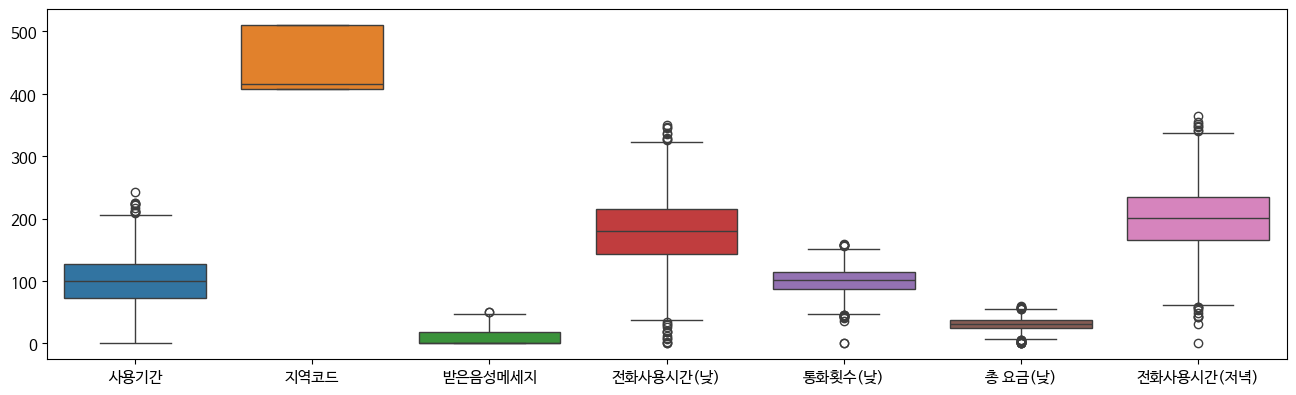

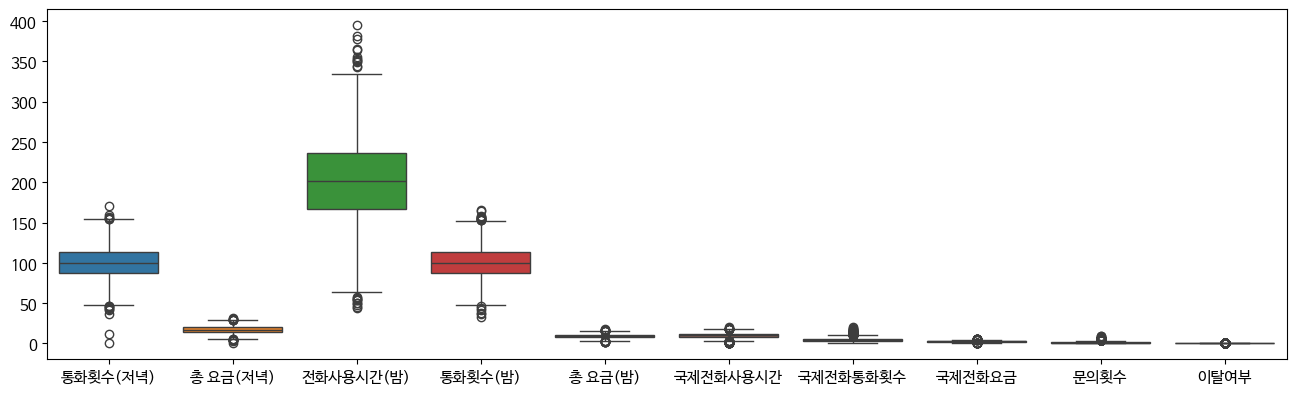

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
sns.boxplot(data=train.iloc[:,:10])
plt.figure(figsize=(16,10))
plt.subplot(2,1,2)
sns.boxplot(data=train.iloc[:,10:])
plt.show()

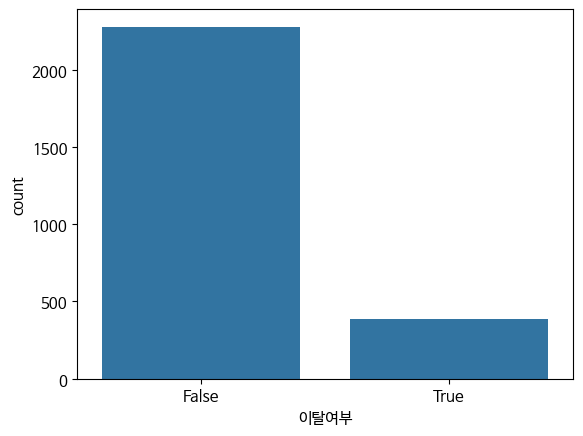

In [ ]:
# 이탈비율
sns.countplot(data=train, x='이탈여부')
plt.show()

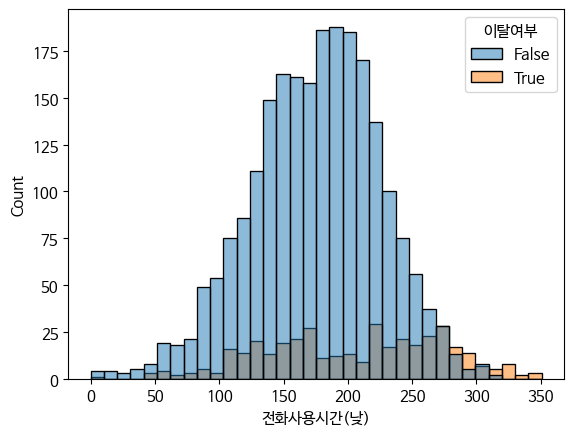

In [ ]:
# 수치형 변수 분포 및 상관관계
sns.histplot(data=train, x='전화사용시간(낮)',hue="이탈여부",)
plt.show()

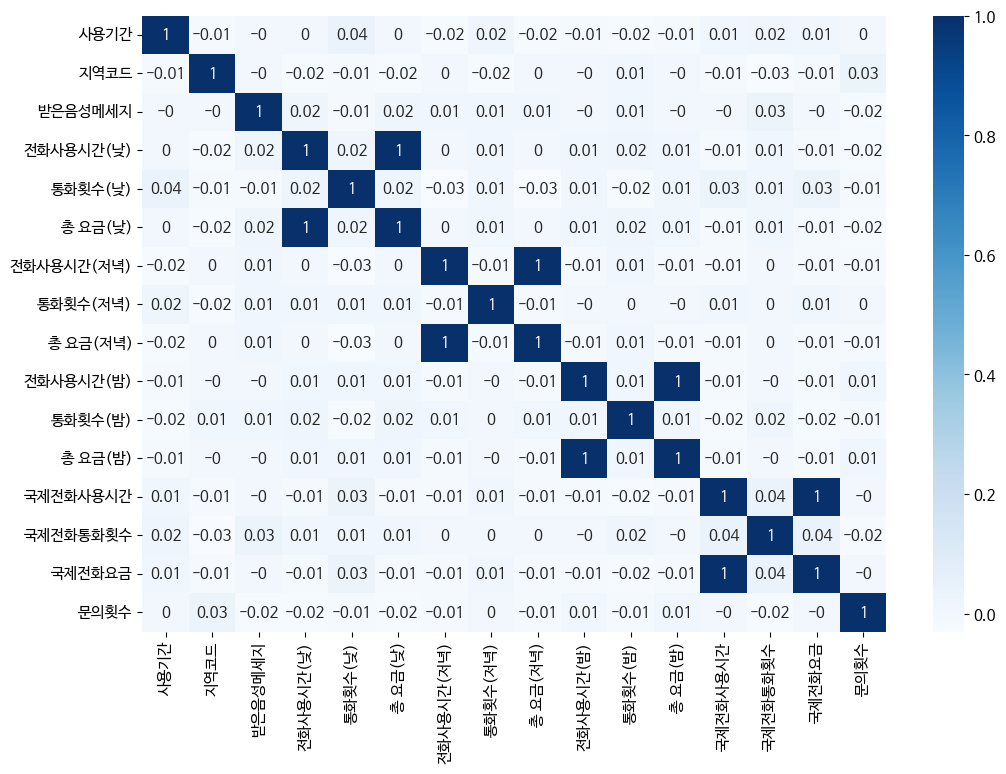

In [ ]:
# 상관관계
numeric_cols = train.select_dtypes(include='number').columns
plt.figure(figsize=(12,8))
sns.heatmap(train[numeric_cols].corr().round(2), annot=True, cmap='Blues')
plt.show()

In [87]:
y = train['이탈여부']
train.drop('이탈여부', axis=1, inplace=True)

In [88]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


category_col = ['거주지역','국제전화이용여부','음성메세지이용여부']
le = LabelEncoder()
ss = StandardScaler()

for col in category_col:
  train[col] = le.fit_transform(train[col])
  test[col] = le.transform(test[col])

train[numeric_cols] = ss.fit_transform(train[numeric_cols])
test[numeric_cols] = ss.transform(test[numeric_cols])



X_tr, X_val, y_tr, y_val = train_test_split(train, y, random_state=42)

rfc = RandomForestClassifier()
rfc.fit(X_tr, y_tr)
pred = rfc.predict(X_val)
print(classification_report(y_val, pred))


              precision    recall  f1-score   support

       False       0.95      0.99      0.97       570
        True       0.96      0.67      0.79        97

    accuracy                           0.95       667
   macro avg       0.95      0.83      0.88       667
weighted avg       0.95      0.95      0.94       667



In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE


category_col = ['거주지역','국제전화이용여부','음성메세지이용여부']
le = LabelEncoder()
ss = StandardScaler()

for col in category_col:
  train[col] = le.fit_transform(train[col])
  test[col] = le.transform(test[col])

train[numeric_cols] = ss.fit_transform(train[numeric_cols])
test[numeric_cols] = ss.transform(test[numeric_cols])

X_tr, X_val, y_tr, y_val = train_test_split(train, y, random_state=42)

smote = SMOTE(random_state=42)
reX_tr, rey_tr = smote.fit_resample(X_tr,y_tr)

rfc = RandomForestClassifier()
rfc.fit(reX_tr, rey_tr)
pred = rfc.predict(X_val)
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

       False       0.95      0.97      0.96       570
        True       0.79      0.72      0.75        97

    accuracy                           0.93       667
   macro avg       0.87      0.84      0.86       667
weighted avg       0.93      0.93      0.93       667



In [95]:
# 데이터 가져오기
import kagglehub
# Download latest version
path = kagglehub.dataset_download("mnassrib/telecom-churn-datasets")

print("Path to dataset files:", path)

# 컬럼한글화
features = [
    "거주지역",
    "사용기간",
    "지역코드",
    "국제전화이용여부",
    "음성메세지이용여부",
    "받은음성메세지수",
    "전화사용시간(낮)",
    "통화횟수(낮)",
    "총요금(낮)",
    "전화사용시간(저녁)",
    "통화횟수(저녁)",
    "총요금(저녁)",
    "전화사용시간(밤)",
    "통화횟수(밤)",
    "총요금(밤)",
    "국제전화사용시간",
    "국제전화통화횟수",
    "국제전화요금",
    "문의횟수",
    "이탈여부"
]

train_df.columns = features
test_df.columns = features


# 범주형 수치형 컬럼 분리
categorical_cols = train_df.select_dtypes(include='object').columns
numeric_cols = train_df.select_dtypes(include='number').columns
#중복데이터 제거
train_df.drop_duplicates(inplace=True)

#범주형 데이터를 군집분석을 통해 수치화
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def convert_to_categorical(df, columns, n_clusters=3):
    for col in columns:
        # Reshape data for clustering
        X = df[col].values.reshape(-1, 1)

        # Standardize the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Apply K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(X_scaled)

        df[col] = clusters


columns_to_convert = [
    '사용기간',
    '지역코드',
    '받은음성메세지수',
    '통화횟수(낮)',
    '통화횟수(저녁)',
    '통화횟수(밤)',
    '국제전화통화횟수',
    '문의횟수'
  ]
convert_to_categorical(train_df, columns_to_convert)
train_df.head()

# 데이터 표준화(수치형 범주형)
from sklearn.preprocessing import LabelEncoder, StandardScaler
label_encoder = LabelEncoder()
X = train_df.drop('이탈여부', axis=1)
y = train_df['이탈여부']
# 수치형 데이터 표준화
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
# 범주형 데이터의 라벨인코딩
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = label_encoder.fit_transform(X[col])

# 모델 별 학습
# Split data into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    }
    return metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Neural Network': MLPClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    results[name] = evaluate_model(model, X_test, y_test)

# Create a DataFrame with the results
results_df = pd.DataFrame(results).T
print("\nModel Comparison Results:")
print(results_df)

# Sort by ROC-AUC score
print("\nModels sorted by ROC-AUC score:")
print(results_df.sort_values('ROC-AUC', ascending=False))

Path to dataset files: /root/.cache/kagglehub/datasets/mnassrib/telecom-churn-datasets/versions/1
Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...
Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Neural Network...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Number of positive: 309, number of negative: 1823
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.144934 -> initscore=-1.774897
[LightGBM] [Info] Start training from score -1.774897

Model Comparison Results:
                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
Logistic Regression  0.863296   0.625000  0.189873  0.291262  0.672277
Random Forest        0.913858   1.000000  0.417722  0.589286  0.853498
Gradient Boosting    0.915730   1.000000  0.430380  0.601770  0.883071
SVM                  0.852060   0.000000  0.000000  0.000000  0.734372
Neural Network       0.

# 개선된 버전
```
주요 개선 사항:
데이터 불균형 처리:
class_weight='balanced' 파라미터 추가 (Logistic Regression, Random Forest, SVM, LightGBM)
XGBoost에 scale_pos_weight=5 추가
stratify=y를 사용하여 train/test 분할 시 클래스 비율 유지
모델 파라미터 최적화:
Random Forest와 Gradient Boosting의 n_estimators 증가 (200)
Neural Network의 max_iter 증가 (1000) 및 early_stopping 추가
Gradient Boosting의 learning_rate 조정 (0.1)
데이터 전처리 개선:
중복 데이터 제거
범주형 데이터에 Label Encoding 적용
수치형 데이터에 StandardScaler 적용
데이터 로딩 및 컬럼명 설정 로직 추가
평가 메트릭 개선:
precision_score에 zero_division=0 파라미터 추가하여 경고 제거
이러한 변경사항들은 다음과 같은 효과를 기대할 수 있습니다:
불균형 데이터 처리로 인한 Recall 향상
모델 파라미터 최적화로 인한 전반적인 성능 향상
데이터 전처리 개선으로 인한 모델 학습 안정성 향상
추가로 고려할 수 있는 개선사항:
하이퍼파라미터 튜닝 (GridSearchCV 사용)
교차 검증 추가
특성 중요도 분석
앙상블 모델 구현
이러한 추가 개선사항을 적용하길 원하시면 말씀해 주세요.
```

In [99]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    }
    return metrics

X_val,y_val,models = None,None,None
def main():
    global X_val,y_val, models
    # Load data
    # Update kagglehub first: pip install --upgrade kagglehub
    import kagglehub
    path = kagglehub.dataset_download("mnassrib/telecom-churn-datasets")

    # Load and preprocess data
    train_df = pd.read_csv(f"{path}/churn-bigml-80.csv")
    test_df = pd.read_csv(f"{path}/churn-bigml-20.csv")

    # Korean column names
    features = [
        "거주지역", "사용기간", "지역코드", "국제전화이용여부", "음성메세지이용여부",
        "받은음성메세지수", "전화사용시간(낮)", "통화횟수(낮)", "총요금(낮)",
        "전화사용시간(저녁)", "통화횟수(저녁)", "총요금(저녁)", "전화사용시간(밤)",
        "통화횟수(밤)", "총요금(밤)", "국제전화사용시간", "국제전화통화횟수",
        "국제전화요금", "문의횟수", "이탈여부"
    ]

    train_df.columns = features
    test_df.columns = features

    # Remove duplicates
    train_df.drop_duplicates(inplace=True)
    test_df.drop_duplicates(inplace=True)

    # Separate features and target
    X = train_df.drop('이탈여부', axis=1)
    y = train_df['이탈여부']
    X_val = test_df.drop('이탈여부', axis=1)
    y_val = test_df['이탈여부']

    # Convert categorical columns
    categorical_cols = X.select_dtypes(include='object').columns
    numeric_cols = X.select_dtypes(include='number').columns

    # Label encoding for categorical columns
    label_encoder = LabelEncoder()
    for col in categorical_cols:
        X[col] = label_encoder.fit_transform(X[col])
        X_val[col] = label_encoder.fit_transform(X_val[col])

    # Scale numeric features
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Initialize models with improved parameters
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=200),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=200, learning_rate=0.1),
        'SVM': SVC(probability=True, random_state=42, class_weight='balanced'),
        'Neural Network': MLPClassifier(random_state=42, max_iter=1000, early_stopping=True),
        'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=5),
        'LightGBM': LGBMClassifier(random_state=42, class_weight='balanced')
    }

    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        results[name] = evaluate_model(model, X_test, y_test)

    # Create a DataFrame with the results
    results_df = pd.DataFrame(results).T
    print("\nModel Comparison Results:")
    print(results_df)

    # Sort by ROC-AUC score
    print("\nModels sorted by ROC-AUC score:")
    print(results_df.sort_values('ROC-AUC', ascending=False))

if __name__ == "__main__":
    main()

Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...
Training SVM...
Training Neural Network...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Number of positive: 310, number of negative: 1822
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2417
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Model Comparison Results:
                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
Logistic Regression  0.747191   0.316129  0.628205  0.420601  0.751940
Random Forest        0.943820   0.961538  0.641026  0.769231  0.893303
Gradient Boosting    0.951311   0.91

In [100]:
# 검증데이터로 최종 평가
# y_pred = models['XGBoost'].predict(X_val)
# y_prob = models['XGBoost'].predict_proba(X_val)[:, 1]
evaluate_model(models['XGBoost'],X_val,y_val)

{'Accuracy': 0.9550224887556222,
 'Precision': 0.9012345679012346,
 'Recall': 0.7684210526315789,
 'F1-Score': 0.8295454545454546,
 'ROC-AUC': np.float64(0.9195620169304378)}

# 2차 개선 - 데이터 증대

In [101]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

def evaluate_model(model, X_test, y_test):
    """
    Evaluate model performance using multiple metrics

    Parameters:
    -----------
    model : sklearn model
        Trained model
    X_test : array-like
        Test features
    y_test : array-like
        Test labels

    Returns:
    --------
    dict
        Dictionary containing evaluation metrics
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    }

    return metrics

def main():
    # Load data
    # Update kagglehub first: pip install --upgrade kagglehub
    import kagglehub
    path = kagglehub.dataset_download("mnassrib/telecom-churn-datasets")

    # Load and preprocess data
    train_df = pd.read_csv(f"{path}/churn-bigml-80.csv")
    test_df = pd.read_csv(f"{path}/churn-bigml-20.csv")

    # Korean column names
    features = [
        "거주지역", "사용기간", "지역코드", "국제전화이용여부", "음성메세지이용여부",
        "받은음성메세지수", "전화사용시간(낮)", "통화횟수(낮)", "총요금(낮)",
        "전화사용시간(저녁)", "통화횟수(저녁)", "총요금(저녁)", "전화사용시간(밤)",
        "통화횟수(밤)", "총요금(밤)", "국제전화사용시간", "국제전화통화횟수",
        "국제전화요금", "문의횟수", "이탈여부"
    ]

    train_df.columns = features
    test_df.columns = features

    # Remove duplicates
    train_df.drop_duplicates(inplace=True)

    # Separate features and target
    X = train_df.drop('이탈여부', axis=1)
    y = train_df['이탈여부']

    # Convert categorical columns
    categorical_cols = X.select_dtypes(include='object').columns
    numeric_cols = X.select_dtypes(include='number').columns

    # Label encoding for categorical columns
    label_encoder = LabelEncoder()
    for col in categorical_cols:
        X[col] = label_encoder.fit_transform(X[col])

    # Scale numeric features
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Define different sampling strategies
    sampling_strategies = {
        'Original': None,
        'SMOTE': SMOTE(random_state=42),
        'ADASYN': ADASYN(random_state=42),
        'BorderlineSMOTE': BorderlineSMOTE(random_state=42),
        'SMOTEENN': SMOTEENN(random_state=42),
        'SMOTE+UnderSampling': Pipeline([
            ('smote', SMOTE(random_state=42)),
            ('under', RandomUnderSampler(random_state=42))
        ])
    }

    # XGBoost parameters for grid search
    param_grid = {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'n_estimators': [100, 200, 300]
    }

    # Initialize XGBoost model
    xgb_model = XGBClassifier(
        random_state=42,
        scale_pos_weight=5,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Results storage
    results = {}

    # Try different sampling strategies
    for strategy_name, sampler in sampling_strategies.items():
        print(f"\nEvaluating with {strategy_name} sampling...")

        # Apply sampling if strategy is not 'Original'
        if sampler is not None:
            X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        else:
            X_resampled, y_resampled = X_train, y_train

        # Grid search with cross-validation
        grid_search = GridSearchCV(
            estimator=xgb_model,
            param_grid=param_grid,
            scoring='roc_auc',
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            n_jobs=-1,
            verbose=1
        )

        # Fit the model
        grid_search.fit(X_resampled, y_resampled)

        # Get best model
        best_model = grid_search.best_estimator_

        # Evaluate on test set
        results[strategy_name] = evaluate_model(best_model, X_test, y_test)

        # Print best parameters
        print(f"Best parameters for {strategy_name}:")
        print(grid_search.best_params_)

    # Create a DataFrame with the results
    results_df = pd.DataFrame(results).T
    print("\nModel Comparison Results with Different Sampling Strategies:")
    print(results_df)

    # Sort by ROC-AUC score
    print("\nModels sorted by ROC-AUC score:")
    print(results_df.sort_values('ROC-AUC', ascending=False))

if __name__ == "__main__":
    main()


Evaluating with Original sampling...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters for Original:
{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}

Evaluating with SMOTE sampling...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits


KeyboardInterrupt: 